In [1]:
# ✅ 1. Imports (Updated for ViT)
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torchvision import transforms, models
from torchvision.models import vit_b_16, ViT_B_16_Weights

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
import time
from tqdm import tqdm
import glob

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [3]:
class LabelSmoothingCrossEntropy(nn.Module):
    """Label smoothing cross entropy loss."""

    def __init__(self, smoothing: float = 0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        loss = (-weight * log_prob).sum(dim=-1).mean()
        return loss


In [4]:
class BreakHisDataset(Dataset):
    """BreakHis dataset class for tumor classification."""

    def __init__(self, image_paths: List[str], labels: List[int],
                 transform: Optional[transforms.Compose] = None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
class EarlyStopping:
    """Early stopping utility."""

    def __init__(self, patience: int = 10, min_delta: float = 0.001,
                 mode: str = 'min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score: float):
        if self.best_score is None:
            self.best_score = val_score
        elif self.mode == 'min':
            if val_score < self.best_score - self.min_delta:
                self.best_score = val_score
                self.counter = 0
            else:
                self.counter += 1
        else:  # mode == 'max'
            if val_score > self.best_score + self.min_delta:
                self.best_score = val_score
                self.counter = 0
            else:
                self.counter += 1

        if self.counter >= self.patience:
            self.early_stop = True

In [6]:
class MetricsCalculator:
    """Utility class for calculating classification metrics."""

    @staticmethod
    def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray,
                         y_pred_proba: np.ndarray) -> Dict[str, float]:
        """Calculate all classification metrics."""

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='binary')
        recall = recall_score(y_true, y_pred, average='binary')
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        f1 = f1_score(y_true, y_pred, average='binary')
        auc_roc = roc_auc_score(y_true, y_pred_proba)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1': f1,
            'auc_roc': auc_roc,
            'confusion_matrix': cm
        }

    @staticmethod
    def plot_confusion_matrix(cm: np.ndarray, title: str = "Confusion Matrix"):
        """Plot confusion matrix heatmap."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Benign', 'Malignant'],
                   yticklabels=['Benign', 'Malignant'])
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

In [7]:
# Modified data transforms in the BreakHisTrainer class
class BreakHisTrainer:
    # ... (keep all existing methods except __init__)

    def __init__(self, data_dir: str, batch_size: int = 32,
                 num_workers: int = 4, device: str = 'cuda'):
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

        # Results storage
        self.results = {}

        # Data transforms - Updated for ViT (224x224 input)
        self.train_transforms = transforms.Compose([
            transforms.Resize(256),  # Slightly larger than 224 for cropping
            transforms.CenterCrop(224),  # ViT standard input size
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2,
                                 saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Add slight translation
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        self.val_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),  # ViT standard input size
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def parse_dataset(self) -> Dict[str, List]:
        print("Parsing BreakHis dataset...")
        possible_paths = [
            os.path.join(self.data_dir, 'BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png'),
            os.path.join(self.data_dir, 'BreaKHis_v1/histology_slides/breast/**/*.png'),
            os.path.join(self.data_dir, 'histology_slides/breast/**/*.png'),
            os.path.join(self.data_dir, '**/*.png'),
        ]

        breast_img_paths = []
        for pattern in possible_paths:
            breast_img_paths = glob.glob(pattern, recursive=True)
            if breast_img_paths:
                print(f"Found images using pattern: {pattern}")
                break

        if not breast_img_paths:
            raise FileNotFoundError(f"No PNG files found in {self.data_dir}.")

        print(f"Found {len(breast_img_paths)} image files")

        data_info = {'image_paths': [], 'labels': [], 'magnifications': [], 'patient_ids': []}

        for img_path in breast_img_paths:
            try:
                path_parts = img_path.split(os.sep)
                if 'benign' in img_path.lower():
                    label = 0
                elif 'malignant' in img_path.lower():
                    label = 1
                else:
                    continue

                filename = os.path.basename(img_path)

                if '-40-' in filename:
                    mag = '40X'
                elif '-100-' in filename:
                    mag = '100X'
                elif '-200-' in filename:
                    mag = '200X'
                elif '-400-' in filename:
                    mag = '400X'
                else:
                    continue

                parts = filename.split('-')
                if len(parts) >= 3:
                    patient_id = '-'.join(parts[:3])
                else:
                    patient_id = filename.split('.')[0]

                data_info['image_paths'].append(img_path)
                data_info['labels'].append(label)
                data_info['magnifications'].append(mag)
                data_info['patient_ids'].append(patient_id)

            except Exception as e:
                print(f"Error processing {img_path}: {e}")

        print(f"Successfully parsed {len(data_info['image_paths'])} images")
        print(f"Benign: {len([l for l in data_info['labels'] if l == 0])}")
        print(f"Malignant: {len([l for l in data_info['labels'] if l == 1])}")
        print(f"Magnifications: {set(data_info['magnifications'])}")
        print(f"Unique patients: {len(set(data_info['patient_ids']))}")

        return data_info

    def create_patient_splits(self, data_info: Dict, test_size: float = 0.2, val_size: float = 0.2) -> Dict[str, Dict]:
        df = pd.DataFrame(data_info)
        patient_labels = df.groupby('patient_ids')['labels'].first().reset_index()

        train_val_patients, test_patients = train_test_split(
            patient_labels['patient_ids'].tolist(),
            test_size=test_size,
            stratify=patient_labels['labels'].tolist(),
            random_state=42
        )

        train_val_labels = patient_labels[patient_labels['patient_ids'].isin(train_val_patients)]['labels'].tolist()
        train_patients, val_patients = train_test_split(
            train_val_patients,
            test_size=val_size / (1 - test_size),
            stratify=train_val_labels,
            random_state=42
        )

        magnifications = ['40X', '100X', '200X', '400X', 'All']
        splits = {}

        for mag in magnifications:
            if mag == 'All':
                mag_mask = pd.Series([True] * len(df))
            else:
                mag_mask = df['magnifications'] == mag

            mag_df = df[mag_mask]

            train_mask = mag_df['patient_ids'].isin(train_patients)
            val_mask = mag_df['patient_ids'].isin(val_patients)
            test_mask = mag_df['patient_ids'].isin(test_patients)

            splits[mag] = {
                'train': {
                    'image_paths': mag_df[train_mask]['image_paths'].tolist(),
                    'labels': mag_df[train_mask]['labels'].tolist()
                },
                'val': {
                    'image_paths': mag_df[val_mask]['image_paths'].tolist(),
                    'labels': mag_df[val_mask]['labels'].tolist()
                },
                'test': {
                    'image_paths': mag_df[test_mask]['image_paths'].tolist(),
                    'labels': mag_df[test_mask]['labels'].tolist()
                }
            }

            print(f"\n{mag} - Train: {len(splits[mag]['train']['labels'])}, "
                  f"Val: {len(splits[mag]['val']['labels'])}, "
                  f"Test: {len(splits[mag]['test']['labels'])}")

        return splits

    def create_data_loaders(self, splits: Dict, magnification: str) -> Dict[str, DataLoader]:
        split_data = splits[magnification]

        train_dataset = BreakHisDataset(
            split_data['train']['image_paths'],
            split_data['train']['labels'],
            self.train_transforms
        )

        val_dataset = BreakHisDataset(
            split_data['val']['image_paths'],
            split_data['val']['labels'],
            self.val_transforms
        )

        test_dataset = BreakHisDataset(
            split_data['test']['image_paths'],
            split_data['test']['labels'],
            self.val_transforms
        )

        train_labels = split_data['train']['labels']
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(train_labels),
            y=train_labels
        )

        sample_weights = [class_weights[label] for label in train_labels]
        sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples=len(sample_weights),
                                        replacement=True)

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size,
                                  sampler=sampler, num_workers=self.num_workers,
                                  pin_memory=True)

        val_loader = DataLoader(val_dataset, batch_size=self.batch_size,
                                shuffle=False, num_workers=self.num_workers,
                                pin_memory=True)

        test_loader = DataLoader(test_dataset, batch_size=self.batch_size,
                                 shuffle=False, num_workers=self.num_workers,
                                 pin_memory=True)

        return {'train': train_loader, 'val': val_loader, 'test': test_loader}

    # Training methods remain the same (ViT has simple output like EfficientNet)
    def train_epoch(self, model: nn.Module, train_loader: DataLoader,
                   criterion: nn.Module, optimizer: torch.optim.Optimizer) -> float:
        """Train for one epoch."""
        model.train()
        total_loss = 0.0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc="Training")):
            images, labels = images.to(self.device), labels.to(self.device)

            optimizer.zero_grad()

            # ViT has simple output (no auxiliary outputs)
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        return total_loss / len(train_loader)

    def validate_epoch(self, model: nn.Module, val_loader: DataLoader,
                      criterion: nn.Module) -> Tuple[float, float]:
        """Validate for one epoch."""
        model.eval()
        total_loss = 0.0
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(self.device), labels.to(self.device)

                # ViT has simple output
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                probs = F.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of malignant

        avg_loss = total_loss / len(val_loader)
        auc_roc = roc_auc_score(all_labels, all_probs)

        return avg_loss, auc_roc

    def test_model(self, model: nn.Module, test_loader: DataLoader) -> Dict[str, float]:
        """Test the model and return metrics."""
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device)

                # ViT has simple output
                outputs = model(images)

                probs = F.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())

        return MetricsCalculator.calculate_metrics(
            np.array(all_labels),
            np.array(all_preds),
            np.array(all_probs)
        )

    # Modified train_magnification method with updated print statements
    def train_magnification(self, splits: Dict, magnification: str,
                          epochs: int = 100) -> Dict[str, float]:
        """Train model for a specific magnification."""

        print(f"\n{'='*60}")
        print(f"Training on {magnification} magnification with Vision Transformer (ViT-B/16)")
        print(f"{'='*60}")

        # Create data loaders
        data_loaders = self.create_data_loaders(splits, magnification)

        # Initialize model
        model = TumorClassifier(num_classes=2, dropout_rate=0.5)
        model.to(self.device)

        # Loss function
        criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

        # Phase 1: Train classifier head with frozen backbone
        print("\nPhase 1: Training classifier head (frozen backbone)")
        model.freeze_backbone()

        optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=0.001, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                    patience=5, verbose=True)
        early_stopping = EarlyStopping(patience=10, mode='max')

        best_auc = 0.0
        best_model_state = None

        for epoch in range(epochs // 2):
            # Training
            train_loss = self.train_epoch(model, data_loaders['train'],
                                        criterion, optimizer)

            # Validation
            val_loss, val_auc = self.validate_epoch(model, data_loaders['val'],
                                                  criterion)

            scheduler.step(val_auc)
            early_stopping(val_auc)

            print(f"Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

            # Save best model
            if val_auc > best_auc:
                best_auc = val_auc
                best_model_state = model.state_dict().copy()

            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Load best model from Phase 1
        model.load_state_dict(best_model_state)

        # Phase 2: Fine-tune with unfrozen last transformer layers
        print("\nPhase 2: Fine-tuning with unfrozen last transformer layers")
        model.unfreeze_last_transformer_layers(num_layers=4)

        optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=0.0001, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                    patience=5, verbose=True)
        early_stopping = EarlyStopping(patience=10, mode='max')

        for epoch in range(epochs // 2):
            # Training
            train_loss = self.train_epoch(model, data_loaders['train'],
                                        criterion, optimizer)

            # Validation
            val_loss, val_auc = self.validate_epoch(model, data_loaders['val'],
                                                  criterion)

            scheduler.step(val_auc)
            early_stopping(val_auc)

            print(f"Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

            # Save best model
            if val_auc > best_auc:
                best_auc = val_auc
                best_model_state = model.state_dict().copy()

            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Load best model and test
        model.load_state_dict(best_model_state)
        test_metrics = self.test_model(model, data_loaders['test'])

        print(f"\nBest validation AUC: {best_auc:.4f}")
        print(f"Test metrics:")
        for metric, value in test_metrics.items():
            if metric != 'confusion_matrix':
                print(f"  {metric}: {value:.4f}")

        # Plot confusion matrix
        cm = test_metrics['confusion_matrix']
        MetricsCalculator.plot_confusion_matrix(cm, f"Confusion Matrix - {magnification} (ViT-B/16)")

        return test_metrics

    def run_all_experiments(self, data_dir: str) -> pd.DataFrame:
        """Run experiments for all magnifications."""

        print("Starting BreakHis tumor classification experiments with Vision Transformer (ViT-B/16)...")

        # Parse dataset
        data_info = self.parse_dataset()

        # Create patient-level splits
        splits = self.create_patient_splits(data_info)

        # Run experiments for each magnification
        magnifications = ['40X', '100X', '200X', '400X', 'All']
        results = []

        for mag in magnifications:
            print(f"\nStarting experiment for {mag}...")
            metrics = self.train_magnification(splits, mag)

            result = {
                'Magnification': mag,
                'Accuracy': metrics['accuracy'],
                'Precision': metrics['precision'],
                'Recall': metrics['recall'],
                'Specificity': metrics['specificity'],
                'F1': metrics['f1'],
                'AUC-ROC': metrics['auc_roc']
            }
            results.append(result)

            # Store confusion matrix separately
            self.results[mag] = {
                'metrics': result,
                'confusion_matrix': metrics['confusion_matrix']
            }

        # Create results DataFrame
        results_df = pd.DataFrame(results)

        # Display results table
        print("\n" + "="*80)
        print("FINAL RESULTS TABLE - Vision Transformer (ViT-B/16)")
        print("="*80)
        print(results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

        return results_df

In [8]:
class TumorClassifier(nn.Module):
    """ViT-based tumor classifier."""

    def __init__(self, num_classes: int = 2, dropout_rate: float = 0.5):
        super().__init__()

        # Load pretrained Vision Transformer (ViT-B/16)
        self.backbone = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

        # Get the number of features from the heads
        num_features = self.backbone.heads.head.in_features

        # Replace the final classifier with a more robust one
        self.backbone.heads.head = nn.Sequential(
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(256, num_classes)
        )

        # Initialize classifier weights
        self._init_classifier_weights()

    def _init_classifier_weights(self):
        """Initialize classifier weights."""
        for m in self.backbone.heads.head.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ViT has a simple forward pass (no auxiliary outputs)
        return self.backbone(x)

    def freeze_backbone(self):
        """Freeze backbone parameters except final classifier."""
        for name, param in self.backbone.named_parameters():
            if 'heads.head' not in name:
                param.requires_grad = False

    def unfreeze_last_transformer_layers(self, num_layers: int = 4):
        """Unfreeze last few transformer blocks of ViT."""
        # ViT has encoder layers organized in a list
        # We'll unfreeze the last few encoder layers

        total_layers = len(self.backbone.encoder.layers)
        layers_to_unfreeze = min(num_layers, total_layers)

        # Unfreeze the last N transformer blocks
        for i in range(total_layers - layers_to_unfreeze, total_layers):
            for param in self.backbone.encoder.layers[i].parameters():
                param.requires_grad = True

        # Also unfreeze the encoder norm layer
        for param in self.backbone.encoder.ln.parameters():
            param.requires_grad = True


In [9]:
# Modified main function
def main():
    """Main function to run the experiments."""

    # Download dataset using kagglehub
    import kagglehub

    # Download dataset
    path = kagglehub.dataset_download("ambarish/breakhis")
    print("Path to dataset files:", path)

    # Configuration
    DATA_DIR = path  # Use the downloaded path
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    print(f"Using device: {DEVICE}")
    print("Using Vision Transformer (ViT-B/16) backbone")

    # Initialize trainer
    trainer = BreakHisTrainer(
        data_dir=DATA_DIR,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        device=DEVICE
    )

    # Run all experiments
    results_df = trainer.run_all_experiments(DATA_DIR)

    # Save results
    results_df.to_csv('breakhis_vit_b16_results.csv', index=False)
    print("\nResults saved to 'breakhis_vit_b16_results.csv'")

    # Display final summary
    print("\n" + "="*80)
    print("EXPERIMENT SUMMARY - Vision Transformer (ViT-B/16)")
    print("="*80)
    print(f"Average Accuracy: {results_df['Accuracy'].mean():.4f}")
    print(f"Average AUC-ROC: {results_df['AUC-ROC'].mean():.4f}")
    print(f"Best performing magnification: {results_df.loc[results_df['Accuracy'].idxmax(), 'Magnification']}")

    return results_df


Path to dataset files: /kaggle/input/breakhis
Using device: cuda
Using Vision Transformer (ViT-B/16) backbone
Starting BreakHis tumor classification experiments with Vision Transformer (ViT-B/16)...
Parsing BreakHis dataset...
Found images using pattern: /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/**/*.png
Found 7909 image files
Successfully parsed 7909 images
Benign: 2480
Malignant: 5429
Magnifications: {'400X', '100X', '40X', '200X'}
Unique patients: 82

40X - Train: 1172, Val: 382, Test: 441

100X - Train: 1201, Val: 403, Test: 477

200X - Train: 1188, Val: 382, Test: 443

400X - Train: 1059, Val: 367, Test: 394

All - Train: 4620, Val: 1534, Test: 1755

Starting experiment for 40X...

Training on 40X magnification with Vision Transformer (ViT-B/16)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 88.3MB/s]



Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]


Epoch   1: Train Loss: 0.5804, Val Loss: 0.6128, Val AUC: 0.8279


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Epoch   2: Train Loss: 0.5123, Val Loss: 0.5189, Val AUC: 0.8607


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Epoch   3: Train Loss: 0.4870, Val Loss: 0.5438, Val AUC: 0.8828


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch   4: Train Loss: 0.4854, Val Loss: 0.5205, Val AUC: 0.8534


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch   5: Train Loss: 0.4788, Val Loss: 0.5273, Val AUC: 0.9018


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch   6: Train Loss: 0.4485, Val Loss: 0.5101, Val AUC: 0.9055


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]


Epoch   7: Train Loss: 0.4518, Val Loss: 0.5225, Val AUC: 0.8967


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Epoch   8: Train Loss: 0.4460, Val Loss: 0.4769, Val AUC: 0.9171


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


Epoch   9: Train Loss: 0.4441, Val Loss: 0.4731, Val AUC: 0.9316


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Epoch  10: Train Loss: 0.4315, Val Loss: 0.5084, Val AUC: 0.9026


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch  11: Train Loss: 0.4191, Val Loss: 0.4876, Val AUC: 0.9211


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Epoch  12: Train Loss: 0.4343, Val Loss: 0.4692, Val AUC: 0.9210


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.90it/s]


Epoch  13: Train Loss: 0.4279, Val Loss: 0.5016, Val AUC: 0.8968


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


Epoch  14: Train Loss: 0.4301, Val Loss: 0.5004, Val AUC: 0.8938


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch  15: Train Loss: 0.4258, Val Loss: 0.4762, Val AUC: 0.9241


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


Epoch  16: Train Loss: 0.4175, Val Loss: 0.4748, Val AUC: 0.9158


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch  17: Train Loss: 0.4085, Val Loss: 0.4664, Val AUC: 0.9239


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Epoch  18: Train Loss: 0.4120, Val Loss: 0.4844, Val AUC: 0.9148


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  19: Train Loss: 0.4032, Val Loss: 0.4636, Val AUC: 0.9260
Early stopping at epoch 19

Phase 2: Fine-tuning with unfrozen last transformer layers


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Epoch   1: Train Loss: 0.4368, Val Loss: 0.4864, Val AUC: 0.8970


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch   2: Train Loss: 0.3963, Val Loss: 0.4594, Val AUC: 0.9343


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch   3: Train Loss: 0.3846, Val Loss: 0.4573, Val AUC: 0.9293


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch   4: Train Loss: 0.3676, Val Loss: 0.4461, Val AUC: 0.9538


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Epoch   5: Train Loss: 0.3621, Val Loss: 0.4497, Val AUC: 0.9440


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Epoch   6: Train Loss: 0.3625, Val Loss: 0.4520, Val AUC: 0.9373


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


Epoch   7: Train Loss: 0.3536, Val Loss: 0.4823, Val AUC: 0.9439


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch   8: Train Loss: 0.3477, Val Loss: 0.4602, Val AUC: 0.9376


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch   9: Train Loss: 0.3466, Val Loss: 0.4441, Val AUC: 0.9477


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Epoch  10: Train Loss: 0.3469, Val Loss: 0.5085, Val AUC: 0.9072


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Epoch  11: Train Loss: 0.3430, Val Loss: 0.4717, Val AUC: 0.9406


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Epoch  12: Train Loss: 0.3412, Val Loss: 0.4618, Val AUC: 0.9342


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch  13: Train Loss: 0.3399, Val Loss: 0.4395, Val AUC: 0.9362


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch  14: Train Loss: 0.3398, Val Loss: 0.4672, Val AUC: 0.9314
Early stopping at epoch 14


Testing: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]



Best validation AUC: 0.9538
Test metrics:
  accuracy: 0.8299
  precision: 0.8286
  recall: 0.8958
  specificity: 0.7363
  f1: 0.8609
  auc_roc: 0.9144


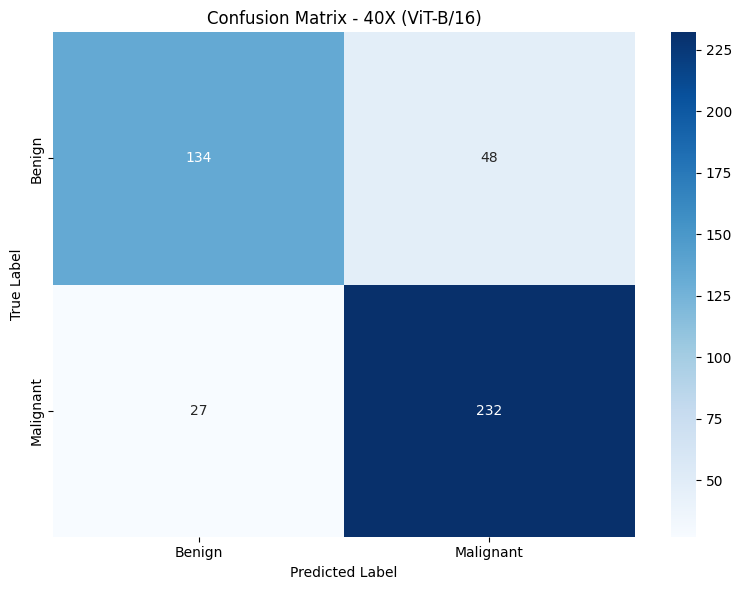


Starting experiment for 100X...

Training on 100X magnification with Vision Transformer (ViT-B/16)

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Epoch   1: Train Loss: 0.5914, Val Loss: 0.5880, Val AUC: 0.8180


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.77it/s]


Epoch   2: Train Loss: 0.5202, Val Loss: 0.5958, Val AUC: 0.8583


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch   3: Train Loss: 0.5046, Val Loss: 0.5238, Val AUC: 0.8752


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch   4: Train Loss: 0.5016, Val Loss: 0.5712, Val AUC: 0.8594


Validation: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch   5: Train Loss: 0.4824, Val Loss: 0.5153, Val AUC: 0.8760


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch   6: Train Loss: 0.4869, Val Loss: 0.5424, Val AUC: 0.8616


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.75it/s]


Epoch   7: Train Loss: 0.4509, Val Loss: 0.5362, Val AUC: 0.8777


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]


Epoch   8: Train Loss: 0.4605, Val Loss: 0.5985, Val AUC: 0.8820


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch   9: Train Loss: 0.4628, Val Loss: 0.5537, Val AUC: 0.8831


Validation: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Epoch  10: Train Loss: 0.4653, Val Loss: 0.5583, Val AUC: 0.8784


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch  11: Train Loss: 0.4557, Val Loss: 0.5426, Val AUC: 0.8845


Validation: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Epoch  12: Train Loss: 0.4583, Val Loss: 0.5576, Val AUC: 0.8894


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch  13: Train Loss: 0.4532, Val Loss: 0.5435, Val AUC: 0.8740


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch  14: Train Loss: 0.4523, Val Loss: 0.5220, Val AUC: 0.8958


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


Epoch  15: Train Loss: 0.4544, Val Loss: 0.5374, Val AUC: 0.8818


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch  16: Train Loss: 0.4442, Val Loss: 0.5849, Val AUC: 0.8899


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.64it/s]


Epoch  17: Train Loss: 0.4424, Val Loss: 0.5560, Val AUC: 0.8777


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch  18: Train Loss: 0.4467, Val Loss: 0.6059, Val AUC: 0.8727


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Epoch  19: Train Loss: 0.4438, Val Loss: 0.6001, Val AUC: 0.8787


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch  20: Train Loss: 0.4521, Val Loss: 0.5461, Val AUC: 0.8909


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.87it/s]


Epoch  21: Train Loss: 0.4357, Val Loss: 0.5292, Val AUC: 0.8909


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch  22: Train Loss: 0.4237, Val Loss: 0.5281, Val AUC: 0.8754


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch  23: Train Loss: 0.4319, Val Loss: 0.5373, Val AUC: 0.8792


Validation: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch  24: Train Loss: 0.4238, Val Loss: 0.5414, Val AUC: 0.8832
Early stopping at epoch 24

Phase 2: Fine-tuning with unfrozen last transformer layers


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]


Epoch   1: Train Loss: 0.4477, Val Loss: 0.5221, Val AUC: 0.8759


Validation: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]


Epoch   2: Train Loss: 0.4157, Val Loss: 0.5676, Val AUC: 0.8708


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch   3: Train Loss: 0.4032, Val Loss: 0.5666, Val AUC: 0.8903


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.89it/s]


Epoch   4: Train Loss: 0.3851, Val Loss: 0.5441, Val AUC: 0.8969


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch   5: Train Loss: 0.3739, Val Loss: 0.5160, Val AUC: 0.9136


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch   6: Train Loss: 0.3725, Val Loss: 0.6032, Val AUC: 0.9247


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Epoch   7: Train Loss: 0.3794, Val Loss: 0.4918, Val AUC: 0.9040


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.67it/s]


Epoch   8: Train Loss: 0.3600, Val Loss: 0.4736, Val AUC: 0.9059


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


Epoch   9: Train Loss: 0.3575, Val Loss: 0.4981, Val AUC: 0.9248


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Epoch  10: Train Loss: 0.3574, Val Loss: 0.5258, Val AUC: 0.9132


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.90it/s]


Epoch  11: Train Loss: 0.3464, Val Loss: 0.5359, Val AUC: 0.8860


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


Epoch  12: Train Loss: 0.3489, Val Loss: 0.5047, Val AUC: 0.9032


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.88it/s]


Epoch  13: Train Loss: 0.3475, Val Loss: 0.5023, Val AUC: 0.8987


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch  14: Train Loss: 0.3460, Val Loss: 0.5303, Val AUC: 0.9260


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]


Epoch  15: Train Loss: 0.3493, Val Loss: 0.5520, Val AUC: 0.9243


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Epoch  16: Train Loss: 0.3449, Val Loss: 0.5388, Val AUC: 0.9326


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Epoch  17: Train Loss: 0.3539, Val Loss: 0.5671, Val AUC: 0.9171


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.79it/s]


Epoch  18: Train Loss: 0.3496, Val Loss: 0.5463, Val AUC: 0.9123


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch  19: Train Loss: 0.3435, Val Loss: 0.5173, Val AUC: 0.9140


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.86it/s]


Epoch  20: Train Loss: 0.3380, Val Loss: 0.5510, Val AUC: 0.8921


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.86it/s]


Epoch  21: Train Loss: 0.3373, Val Loss: 0.5668, Val AUC: 0.9001


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch  22: Train Loss: 0.3361, Val Loss: 0.5552, Val AUC: 0.9127


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


Epoch  23: Train Loss: 0.3360, Val Loss: 0.5468, Val AUC: 0.9165


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


Epoch  24: Train Loss: 0.3393, Val Loss: 0.5338, Val AUC: 0.9274


Validation: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]


Epoch  25: Train Loss: 0.3378, Val Loss: 0.5573, Val AUC: 0.9163


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.81it/s]


Epoch  26: Train Loss: 0.3378, Val Loss: 0.5343, Val AUC: 0.9232
Early stopping at epoch 26


Testing: 100%|██████████| 15/15 [00:08<00:00,  1.77it/s]



Best validation AUC: 0.9326
Test metrics:
  accuracy: 0.9140
  precision: 0.9324
  recall: 0.9293
  specificity: 0.8889
  f1: 0.9309
  auc_roc: 0.9267


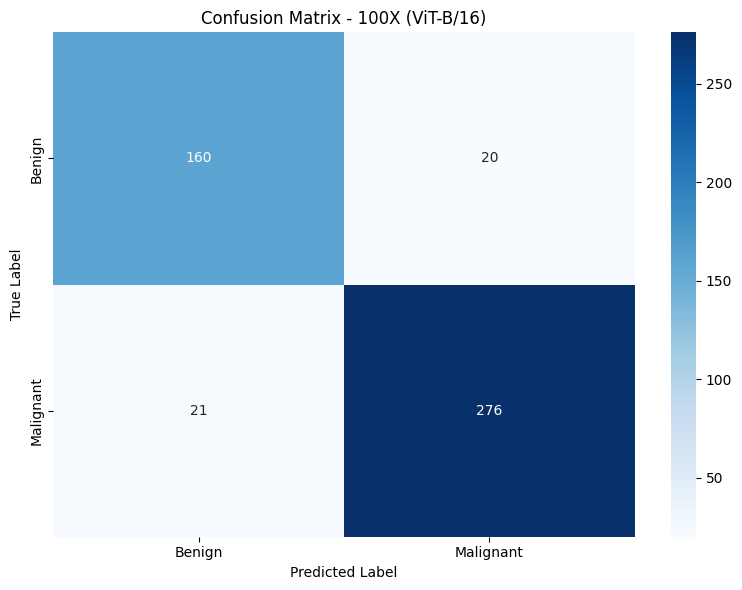


Starting experiment for 200X...

Training on 200X magnification with Vision Transformer (ViT-B/16)

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 12/12 [00:08<00:00,  1.50it/s]


Epoch   1: Train Loss: 0.5749, Val Loss: 0.6162, Val AUC: 0.8145


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch   2: Train Loss: 0.4986, Val Loss: 0.5481, Val AUC: 0.8502


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch   3: Train Loss: 0.4874, Val Loss: 0.5760, Val AUC: 0.8493


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Epoch   4: Train Loss: 0.4783, Val Loss: 0.5658, Val AUC: 0.8733


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch   5: Train Loss: 0.4619, Val Loss: 0.5418, Val AUC: 0.8786


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Epoch   6: Train Loss: 0.4566, Val Loss: 0.5331, Val AUC: 0.8974


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch   7: Train Loss: 0.4589, Val Loss: 0.5319, Val AUC: 0.8737


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch   8: Train Loss: 0.4366, Val Loss: 0.5165, Val AUC: 0.8999


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch   9: Train Loss: 0.4595, Val Loss: 0.5287, Val AUC: 0.8808


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


Epoch  10: Train Loss: 0.4344, Val Loss: 0.5489, Val AUC: 0.8938


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch  11: Train Loss: 0.4299, Val Loss: 0.5538, Val AUC: 0.8772


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


Epoch  12: Train Loss: 0.4415, Val Loss: 0.5470, Val AUC: 0.8650


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  13: Train Loss: 0.4377, Val Loss: 0.5093, Val AUC: 0.8834


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Epoch  14: Train Loss: 0.4154, Val Loss: 0.5138, Val AUC: 0.8870


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch  15: Train Loss: 0.4309, Val Loss: 0.5053, Val AUC: 0.8989


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


Epoch  16: Train Loss: 0.4202, Val Loss: 0.5080, Val AUC: 0.8975


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch  17: Train Loss: 0.4321, Val Loss: 0.5188, Val AUC: 0.8773


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Epoch  18: Train Loss: 0.4188, Val Loss: 0.5124, Val AUC: 0.8883
Early stopping at epoch 18

Phase 2: Fine-tuning with unfrozen last transformer layers


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Epoch   1: Train Loss: 0.4393, Val Loss: 0.4960, Val AUC: 0.9065


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch   2: Train Loss: 0.4016, Val Loss: 0.4914, Val AUC: 0.9181


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch   3: Train Loss: 0.3858, Val Loss: 0.5135, Val AUC: 0.9000


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Epoch   4: Train Loss: 0.3702, Val Loss: 0.4779, Val AUC: 0.9417


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Epoch   5: Train Loss: 0.3758, Val Loss: 0.4940, Val AUC: 0.9192


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


Epoch   6: Train Loss: 0.3590, Val Loss: 0.5095, Val AUC: 0.9070


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch   7: Train Loss: 0.3499, Val Loss: 0.5115, Val AUC: 0.8847


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch   8: Train Loss: 0.3503, Val Loss: 0.4874, Val AUC: 0.9057


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch   9: Train Loss: 0.3452, Val Loss: 0.4861, Val AUC: 0.9334


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  10: Train Loss: 0.3515, Val Loss: 0.5104, Val AUC: 0.9394


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


Epoch  11: Train Loss: 0.3540, Val Loss: 0.4830, Val AUC: 0.9271


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch  12: Train Loss: 0.3413, Val Loss: 0.4924, Val AUC: 0.9238


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch  13: Train Loss: 0.3394, Val Loss: 0.4897, Val AUC: 0.9262


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch  14: Train Loss: 0.3395, Val Loss: 0.5035, Val AUC: 0.9092
Early stopping at epoch 14


Testing: 100%|██████████| 14/14 [00:08<00:00,  1.61it/s]



Best validation AUC: 0.9417
Test metrics:
  accuracy: 0.8488
  precision: 0.8679
  recall: 0.8901
  specificity: 0.7824
  f1: 0.8788
  auc_roc: 0.8711


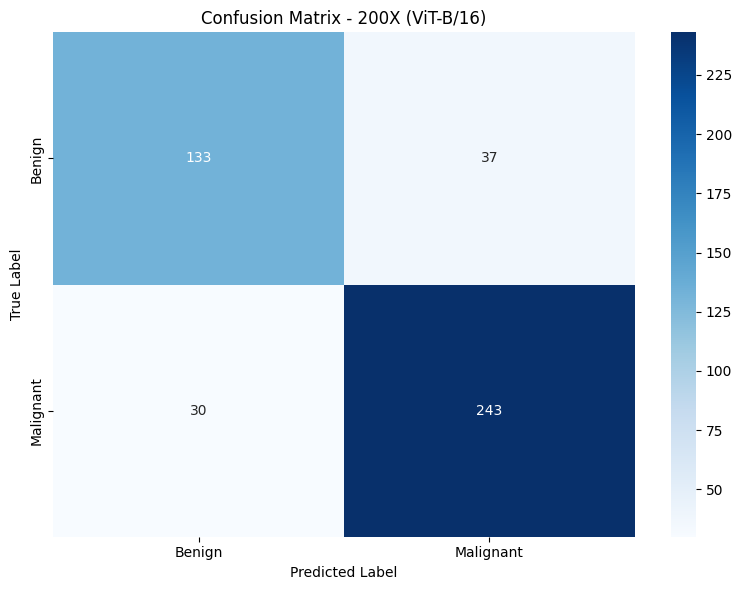


Starting experiment for 400X...

Training on 400X magnification with Vision Transformer (ViT-B/16)

Phase 1: Training classifier head (frozen backbone)


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch   1: Train Loss: 0.5974, Val Loss: 0.5750, Val AUC: 0.8897


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch   2: Train Loss: 0.5382, Val Loss: 0.5794, Val AUC: 0.8870


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.60it/s]


Epoch   3: Train Loss: 0.4983, Val Loss: 0.5617, Val AUC: 0.8978


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch   4: Train Loss: 0.5110, Val Loss: 0.5641, Val AUC: 0.9144


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.84it/s]


Epoch   5: Train Loss: 0.4764, Val Loss: 0.5398, Val AUC: 0.9084


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch   6: Train Loss: 0.4862, Val Loss: 0.5753, Val AUC: 0.9103


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Epoch   7: Train Loss: 0.4693, Val Loss: 0.5035, Val AUC: 0.9260


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch   8: Train Loss: 0.4658, Val Loss: 0.5488, Val AUC: 0.9030


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch   9: Train Loss: 0.4613, Val Loss: 0.5619, Val AUC: 0.8974


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  10: Train Loss: 0.4540, Val Loss: 0.5501, Val AUC: 0.9228


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.87it/s]


Epoch  11: Train Loss: 0.4432, Val Loss: 0.5719, Val AUC: 0.9282


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Epoch  12: Train Loss: 0.4461, Val Loss: 0.5637, Val AUC: 0.9216


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


Epoch  13: Train Loss: 0.4556, Val Loss: 0.5427, Val AUC: 0.9303


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Epoch  14: Train Loss: 0.4458, Val Loss: 0.5237, Val AUC: 0.9235


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch  15: Train Loss: 0.4434, Val Loss: 0.5861, Val AUC: 0.9118


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


Epoch  16: Train Loss: 0.4422, Val Loss: 0.5875, Val AUC: 0.9259


Validation:   8%|▊         | 1/12 [00:02<00:25,  2.32s/it]

In [ ]:

if __name__ == "__main__":
    results = main()